# Comparative Study on News Article Category Classification - Dohyun, Gurmanjot, Yuxuan


In [ ]:
# Imports
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torchtext
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files


uploaded = files.upload()

Saving bbc-news-data.csv to bbc-news-data.csv


## Explatory Data Analysis

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64
Ad sales boost Time Warner profit Quarterly profits US media giant TimeWarner jumped 76% $1.13bn (£600m) three months December, $639m year-earlier.  The firm, one biggest investors Google, benefited sales high-speed internet connections higher advert sales. TimeWarner said fourth quarter sales rose 2% $11.1bn $10.9bn. Its profits buoyed one-off gains offset profit dip Warner Bros, less users AOL.  Time Warner said Friday owns 8% search-engine Google. But internet business, AOL, mixed fortunes. It lost 464,000 subscribers fourth quarter profits lower preceding three quarters. However, company said AOL's underlying profit exceptional items rose 8% back stronger internet advertising revenues. It hopes increase subscribers offering online service free TimeWarner internet customers try sign AOL's existing customers high-speed broadband. TimeWarner also 

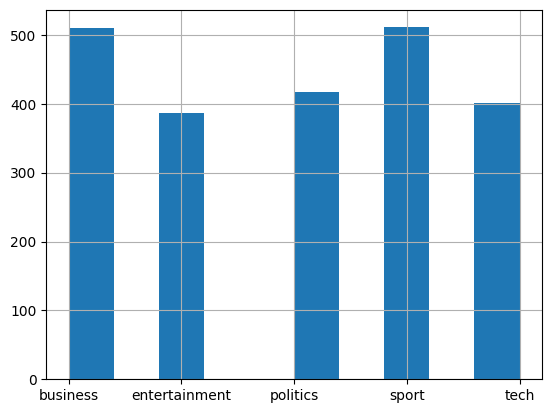

In [ ]:
# Load data
df = pd.read_csv('/content/bbc-news-data.csv', sep="\t") # Have to upload csv file every single time colab restarts (use folder icon on the left)
df = df.drop(columns=['filename'])

# Table
print(df.category.value_counts())

# Histogram
df["category"].hist()

# Clean data

# Replace str category into int (0-4)
conditions = [
    (df['category'] == 'business'),
    (df['category'] == 'entertainment'),
    (df['category'] == 'politics'),
    (df['category'] == 'sport'),
    (df['category'] == 'tech')
    ]
values = [0, 1, 2, 3, 4]
df['category'] = np.select(conditions, values)

# Combine title and content
df['text'] = df['title'] + df['content']

stopwords = set(stopwords.words('english'))

without_stopwords = []
for text in df.text:
    for word in stopwords:
        token = " " + word + " "
        text = text.replace(token, " ")
    without_stopwords.append(text)

df['text'] = np.array(without_stopwords)

data = list(zip(df.text, df.category))

# First data point
print(data[0][0])
print(data[0][1])

## Coding Part

In [ ]:
random.seed(413)
random.shuffle(data)

print(len(data))

train_data = data[:1335] # 60%
val_data = data[1335:1780] # 20%
test_data = data[1780:] # 20%

print(len(train_data), len(val_data), len(test_data))

2225
1335 445 445


In [ ]:
tokenizer = get_tokenizer("basic_english")
glove = torchtext.vocab.GloVe(name="6B", dim=300)

def convert_indices_glove(data, default=len(glove)-1):
    result = []
    for text, label in data:
        words = tokenizer(text)
        indices = []
        for w in words:
            if w in glove.stoi:
                indices.append(glove.stoi[w])
            else:
                indices.append(default)
        result.append((indices, label))
    return result

# Train, validation, and test data sets
train_data_glove = convert_indices_glove(train_data)
val_data_glove = convert_indices_glove(val_data)
test_data_glove = convert_indices_glove(test_data)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [01:03<00:00, 6296.13it/s]


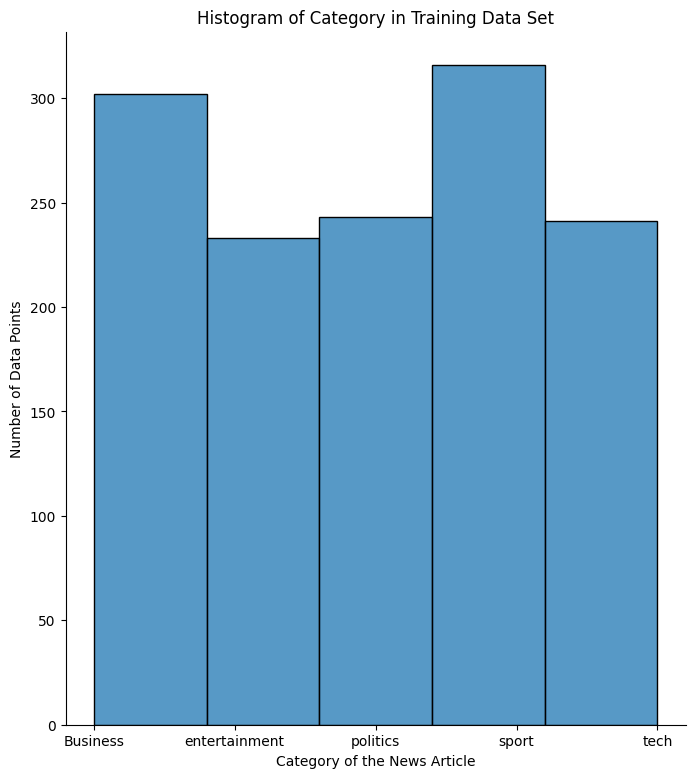

In [ ]:
# Histogram of category for each data set
plt.figure(figsize = (8,9))
h = sns.histplot(list(zip(*train_data_glove))[1], bins=5)
h.set_xticks([0, 1, 2, 3, 4])
h.set_xticklabels(["Business", "entertainment", "politics", "sport", "tech"])
plt.title("Histogram of Category in Training Data Set")
plt.ylabel("Number of Data Points")
plt.xlabel("Category of the News Article")
sns.despine()
plt.show()

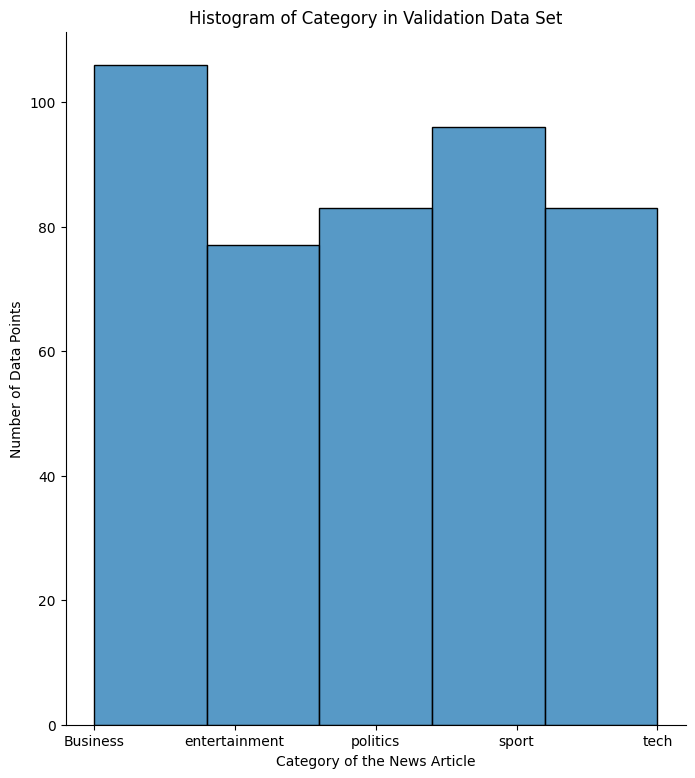

In [ ]:
plt.figure(figsize = (8,9))
h = sns.histplot(list(zip(*val_data_glove))[1], bins=5)
h.set_xticks([0, 1, 2, 3, 4])
h.set_xticklabels(["Business", "entertainment", "politics", "sport", "tech"])
plt.title("Histogram of Category in Validation Data Set")
plt.ylabel("Number of Data Points")
plt.xlabel("Category of the News Article")
sns.despine()
plt.show()

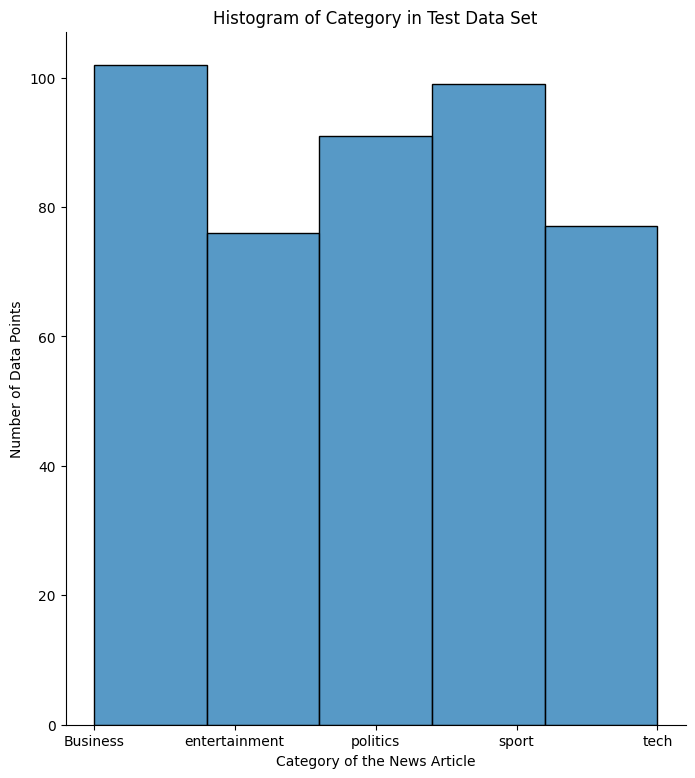

In [ ]:
plt.figure(figsize = (8,9))
h = sns.histplot(list(zip(*test_data_glove))[1], bins=5)
h.set_xticks([0, 1, 2, 3, 4])
h.set_xticklabels(["Business", "entertainment", "politics", "sport", "tech"])
plt.title("Histogram of Category in Test Data Set")
plt.ylabel("Number of Data Points")
plt.xlabel("Category of the News Article")
sns.despine()
plt.show()

In [ ]:
def collate_batch(batch):
    text_list = []
    label_list = []
    for (text_indices, label) in batch:
        text_list.append(torch.tensor(text_indices))
        label_list.append(torch.Tensor([label]))
    X = pad_sequence(text_list, padding_value=3).transpose(0, 1)
    t = torch.squeeze(pad_sequence(label_list), dim=0)
    return X, t


def accuracy(model, dataset):
    correct, total = 0, 0
    dataloader = DataLoader(dataset,
                            batch_size=1,
                            collate_fn=collate_batch)
    for i, (x, t) in enumerate(dataloader):
        z = model(x)
        y = torch.argmax(z, axis=1)
        correct += int(torch.sum(t == y))
        total   += 1
    return correct / total


def train_model(model,
                train_data,
                val_data,
                learning_rate=0.001,
                batch_size=100,
                num_epochs=10,
                plot_every=50,
                plot=True):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               collate_fn=collate_batch,
                                               shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0

    try:
        for e in range(num_epochs):
            for i, (texts, labels) in enumerate(train_loader):
                z = model(texts)

                loss = criterion(z, labels.long())

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    iters.append(iter_count)
                    ta = accuracy(model, train_data)
                    va = accuracy(model, val_data)
                    train_loss.append(float(loss))
                    train_acc.append(ta)
                    val_acc.append(va)
                    print(iter_count, "Loss:", float(loss), "Train Acc:", ta, "Val Acc:", va)
    finally:
        if plot:
            plt.figure()
            plt.plot(iters[:len(train_loss)], train_loss)
            plt.title("Loss over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")

            plt.figure()
            plt.plot(iters[:len(train_acc)], train_acc)
            plt.plot(iters[:len(val_acc)], val_acc)
            plt.title("Accuracy over iterations")
            plt.xlabel("Iterations")
            plt.ylabel("Accuracy")
            plt.legend(["Train", "Validation"])

### Convolutional Neural Network (CNN) -- Yuxuan Wang


In [ ]:
from torchvision import models
import torch.nn.functional as F

In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim):
        super(CustomResNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(glove.vectors))  # Assuming glove vectors are loaded correctly
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        # Load pre-trained ResNet-169
        self.resnet = models.resnet50(pretrained=True)
        # Adjust first conv layer to accept 1 channel input if needed
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the fully connected layer to match the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Embed token indices
        x = self.embedding(x)  # x should be (batch_size, sequence_length)

        # Assume each embedding is 50-dim and sequence_length is 376
        # Reshape to (batch_size, 1, 50, 376) - treating as a single channel image
        x = x.unsqueeze(1)

        # Resize embeddings to match input size of ResNet (224x224)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Pass through ResNet
        x = self.resnet(x)
        return x

# Example usage:
resnet_model = CustomResNet(num_classes=5, vocab_size=len(glove.vectors), embedding_dim=glove.vectors.shape[1])

In [ ]:
train_model(resnet_model, train_data_glove, val_data_glove,
            learning_rate=0.001,
            batch_size=5,
            num_epochs=15,
            plot_every=100)

In [ ]:
print("Test accuracy of Resnet: ", accuracy(resnet_model, test_data_glove))

### Recurrent Neural Network (RNN) -  Dohyun Kim

In [ ]:
# RNN (RNN, LSTM, and GRU)

class RNN(nn.Module):

    def __init__(self, hidden_size, num_classes, num_layers=1,
                 model_type='RNN'):
        super(RNN, self).__init__()
        self.vocab_size, self.emb_size = glove.vectors.shape
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.num_layers = num_layers

        self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze = True)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(self.emb_size, self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(self.emb_size, self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        else:
            self.rnn = nn.RNN(self.emb_size, self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, X):
        embedded = self.emb(X)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded)
        output = self.fc(output[:, -1, :])

        return output

100 Loss: 1.5039597749710083 Train Acc: 0.22172284644194756 Val Acc: 0.20674157303370785
200 Loss: 1.5456531047821045 Train Acc: 0.2352059925093633 Val Acc: 0.2157303370786517
300 Loss: 1.7224794626235962 Train Acc: 0.24119850187265918 Val Acc: 0.2157303370786517
400 Loss: 1.5458652973175049 Train Acc: 0.23295880149812734 Val Acc: 0.21123595505617979
500 Loss: 1.5392571687698364 Train Acc: 0.24269662921348314 Val Acc: 0.19325842696629214
600 Loss: 1.576415777206421 Train Acc: 0.24868913857677902 Val Acc: 0.21797752808988763
700 Loss: 1.5525506734848022 Train Acc: 0.2554307116104869 Val Acc: 0.25842696629213485
800 Loss: 1.4396220445632935 Train Acc: 0.23071161048689137 Val Acc: 0.21348314606741572
900 Loss: 1.5658035278320312 Train Acc: 0.22846441947565543 Val Acc: 0.2157303370786517
1000 Loss: 1.6979831457138062 Train Acc: 0.2389513108614232 Val Acc: 0.23820224719101124
1100 Loss: 1.5359368324279785 Train Acc: 0.22771535580524344 Val Acc: 0.24943820224719102
1200 Loss: 1.6991977691650

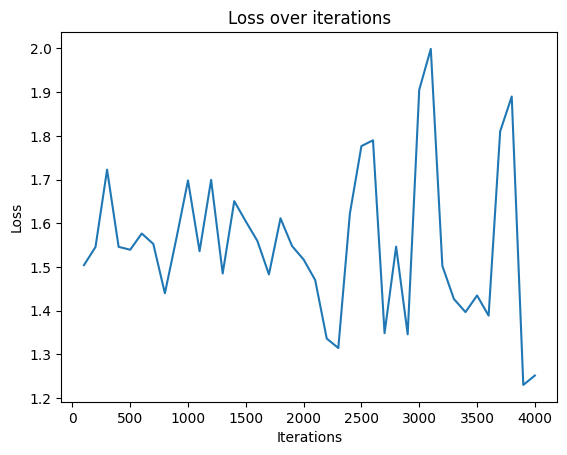

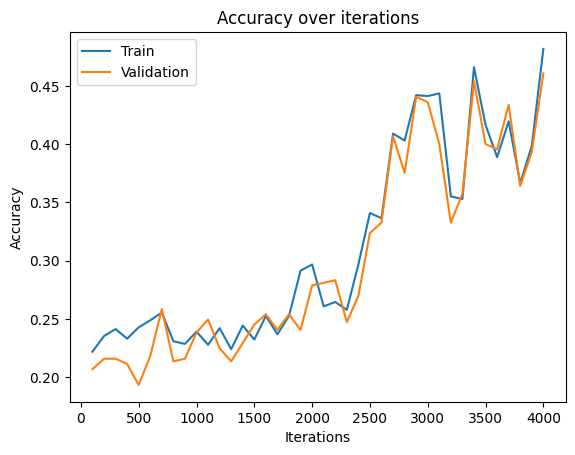

In [ ]:
# RNN
rnn_model = RNN(64, 5, 3)
train_model(rnn_model, train_data_glove, val_data_glove,
            learning_rate=0.0001,
            batch_size=5,
            num_epochs=15,
            plot_every=100)

100 Loss: 1.5823071002960205 Train Acc: 0.23670411985018727 Val Acc: 0.2157303370786517
200 Loss: 1.5795886516571045 Train Acc: 0.23670411985018727 Val Acc: 0.2157303370786517
300 Loss: 1.5832456350326538 Train Acc: 0.23670411985018727 Val Acc: 0.2157303370786517
400 Loss: 1.6344892978668213 Train Acc: 0.24194756554307117 Val Acc: 0.21797752808988763
500 Loss: 1.4877783060073853 Train Acc: 0.27490636704119853 Val Acc: 0.2539325842696629
600 Loss: 1.548434853553772 Train Acc: 0.250187265917603 Val Acc: 0.24269662921348314
700 Loss: 1.525482416152954 Train Acc: 0.20973782771535582 Val Acc: 0.2247191011235955
800 Loss: 1.5478302240371704 Train Acc: 0.18352059925093633 Val Acc: 0.19325842696629214
900 Loss: 1.6920677423477173 Train Acc: 0.1850187265917603 Val Acc: 0.19775280898876405
1000 Loss: 1.4965416193008423 Train Acc: 0.21123595505617979 Val Acc: 0.2247191011235955
1100 Loss: 1.729185700416565 Train Acc: 0.27191011235955054 Val Acc: 0.2651685393258427
1200 Loss: 1.414198637008667 Tra

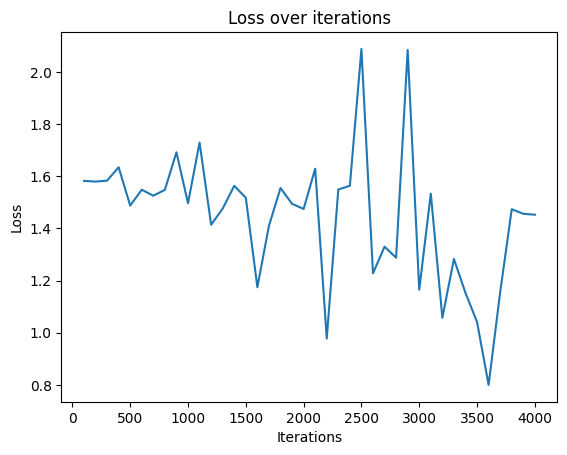

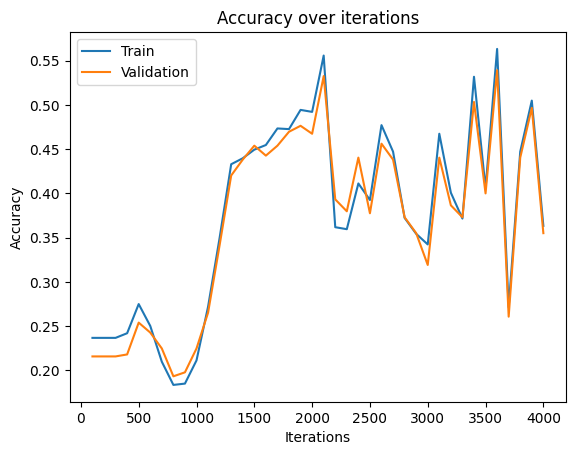

In [ ]:
# LSTM
lstm_model = RNN(64, 5, 3, 'LSTM')
train_model(lstm_model, train_data_glove, val_data_glove,
            learning_rate=0.0001,
            batch_size=5,
            num_epochs=15,
            plot_every=100)

100 Loss: 1.636934518814087 Train Acc: 0.2397003745318352 Val Acc: 0.2606741573033708
200 Loss: 1.624969244003296 Train Acc: 0.27415730337078653 Val Acc: 0.2808988764044944
300 Loss: 1.6268317699432373 Train Acc: 0.30112359550561796 Val Acc: 0.32808988764044944
400 Loss: 1.525414228439331 Train Acc: 0.2441947565543071 Val Acc: 0.251685393258427
500 Loss: 1.5762516260147095 Train Acc: 0.2104868913857678 Val Acc: 0.22247191011235956
600 Loss: 1.6235625743865967 Train Acc: 0.23071161048689137 Val Acc: 0.24269662921348314
700 Loss: 1.7814480066299438 Train Acc: 0.1902621722846442 Val Acc: 0.21123595505617979
800 Loss: 1.661855697631836 Train Acc: 0.1842696629213483 Val Acc: 0.18876404494382024
900 Loss: 1.3937933444976807 Train Acc: 0.18127340823970037 Val Acc: 0.19101123595505617
1000 Loss: 1.4716097116470337 Train Acc: 0.18726591760299627 Val Acc: 0.19550561797752808
1100 Loss: 1.5192618370056152 Train Acc: 0.19775280898876405 Val Acc: 0.22247191011235956
1200 Loss: 1.611690878868103 Tra

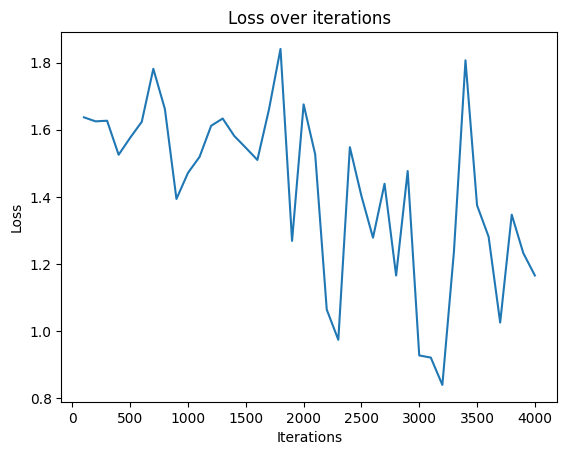

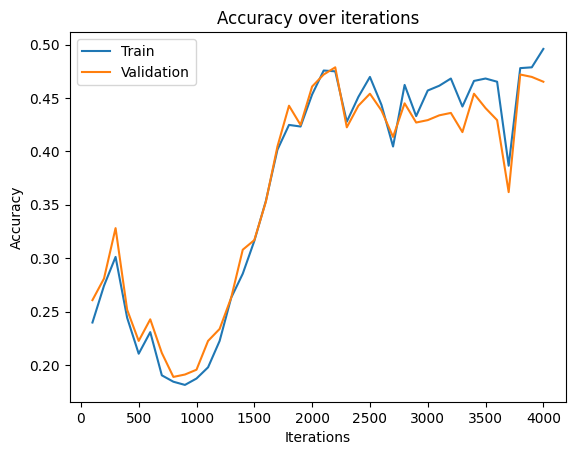

In [ ]:
# GRU
gru_model = RNN(64, 5, 3, 'GRU')
train_model(gru_model, train_data_glove, val_data_glove,
            learning_rate=0.0001,
            batch_size=5,
            num_epochs=15,
            plot_every=100)

In [ ]:
# Test accuracies
print("Test accuracy of RNN: ", accuracy(rnn_model, test_data_glove))
print("Test accuracy of LSTM: ", accuracy(lstm_model, test_data_glove))
# print("Test accuracy of GRU: ", accuracy(gru_model, test_data_glove))

Test accuracy of RNN:  0.451685393258427
Test accuracy of LSTM:  0.3865168539325843


### Transformer - Gurmanjot Singh

In [ ]:
# Implementation of transformer using
class PositionEmbedding(nn.Module):
    """
    The positional embedding module used with the regular vocabulary embedding
    in Transformer.
    """
    def __init__(self, emb_size, dropout=0.1, max_len=5000):
        super(PositionEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pemb = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        denom = torch.exp(torch.arange(0, emb_size, 2).float() * \
                    (-np.log(10000.0) / emb_size))
        pemb[:, 0::2] = torch.sin(position * denom)
        pemb[:, 1::2] = torch.cos(position * denom)
        pemb = pemb.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pemb', pemb)

    def forward(self, x):
        x = x + self.pemb[:x.size(0),:]
        x = self.dropout(x)
        return x

class Transformer(nn.Module):
    """A transformer model using 6 encoder and decoder layers with 6 heads, a
    dropout of 0.1, and intermediary layers of size 500.

    """
    def __init__(self, num_layers=6, dropout=0.1, num_heads=6,
                ff_dim=500, max_len=5000, num_classes=5):
        super(Transformer, self).__init__()
        self.vocab_size, self.emb_size = glove.vectors.shape
        self.dropout = dropout
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.max_len = max_len
        self.num_classes = num_classes

        self.vemb = nn.Embedding.from_pretrained(glove.vectors, freeze = True)

        self.pemb = PositionEmbedding(self.emb_size, self.dropout, self.max_len)
        self.pemb.pemb.require_grads = False

        self.transformerlayer = nn.TransformerEncoderLayer(d_model=self.emb_size,
                                                      nhead=self.num_heads,
                                                      dim_feedforward=self.ff_dim,
                                                      dropout=self.dropout,
                                                      batch_first=True
                                                      )

        self.transformer = nn.TransformerEncoder(self.transformerlayer,
                                                 num_layers=self.num_layers)

        self.fc = nn.Linear(self.emb_size, self.num_classes)

    def forward(self, idx):
        X = self.vemb(idx)
        X = self.pemb(X)
        pad_mask = self.get_pad_mask(idx)
        causal_mask = self.get_causal_mask(idx)
        X = self.transformer(src=X,
                             mask=causal_mask,
                             src_key_padding_mask=pad_mask, is_causal=True
                             )
        X = self.fc(X)
        X = torch.mean(X, dim=1)
        return X

    def get_pad_mask(self, idx):
        return (idx == 3).float()

    def get_causal_mask(self, idx):
        b, t = idx.shape
        mask = torch.tril(torch.ones(t, t) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

In [ ]:
tmodel = Transformer(num_layers=3, num_heads=2,
                                ff_dim=64)

In [ ]:
# Model training
train_model(tmodel, train_data_glove, val_data_glove,
            learning_rate=0.0001,
            batch_size=5,
            num_epochs=15,
            plot_every=100)

In [ ]:
# Example:
examples = collate_batch(train_data_glove)
example = examples[0][0:20]
tmodel(example)

In [ ]:
# Test accuracies
print("Test accuracy of Transformer: ", accuracy(tmodel, test_data_glove))